# Iordache Adrian-Razvan, Artificial Intelligence, 407

# Modules and Packages

In [1]:
import os
import glob
import pickle
import cv2 as cv
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

from PIL import Image
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
print("All Modules Imported")

All Modules Imported


# Task 1 - extracting configurations of Classic Sudoku puzzles


In the first task you are asked to write a program that processes an input image containing a Classic Sudoku puzzle and outputs the configuration of the puzzle by determining whether or not a cell contains a digit. 

We mark empty cells with letter ’o’ and the filled in cells with letter ’x’. The training data consists of 50 training examples. Each training example (an image obtained by taking a photo with the mobile phone) contains one Classic Sudoku puzzle, centered, usually axis aligned or with small rotations with respect to the
Ox and Oy axis.

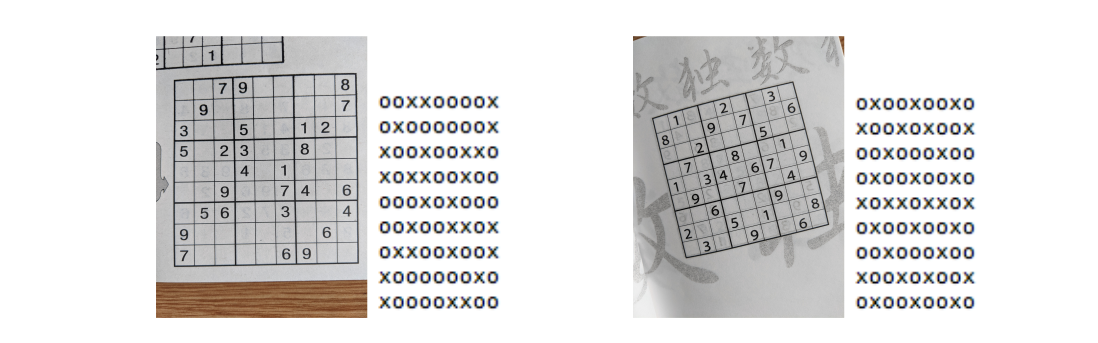

# Problem Description

The main idea of this project is based on finding a robust approach to always detect the Sudoku Bounding Box without external noise (edges, shapes, etc.). The reason for that is because if we accurately detect the bounding box, we can use any type of persective transforms, pixel level transforms to generate a 9x9 grid and after that we can simply iterate through batches of pixels predicting what we need.

The main question remains:
### How do we always find the Sudoku Square?
Before I answer this question we'll propose a simple algorithm for solving task 1

# Proposed Solution
For each image that we have:
- Choose a robust preprocessing way to be able to detect the sudoku square without noise
- Apply a Canny Filter for edge detection (it's easier to find contours there)
- Generate all posible contours on that image
- Pick the "best" contour (this ideally represents the Sudoku Square, attention, this might not be the largest square in the image)
- Apply a perspective transform based on the (ordered) corners of that contour to remove possible rotations
- Apply some more preprocessing to the obtained image for the inference step
- Based on the fact that we now the obtained image should be a 9x9 grid, iterate through patches of pixels
- Based on a chosen threshold and the mean intensity of the patch, predict if the image contains or not some digit

# Implementation

# Initial Preprocessing for contour extraction
Based on multiple experiments on the train set and hard examples I used for preprocessing the following:
- Median Blur with 3x3 kernel for reducing noise and possible sharp edges
- 1 iteration of erosion followed by dilation with a 7x7 grid to be remove as much noise, but in the same time to conserve the main features
- 3 iterations of erosion with a grid of 3x3 to try to remove any small features and keep only the main square 

In [2]:
def preprocessing(image):
    image  = cv.medianBlur(image, 3)
    kernel = np.ones((7, 7), np.uint8)
    image  = cv.morphologyEx(image, cv.MORPH_OPEN, kernel, iterations = 1)
    kernel = np.ones((3, 3), np.uint8)
    image  = cv.erode(image, kernel, iterations = 3)
    return image

# The methodology for finding the best contour
The main idea: 
- Before the inference step compute the largest area given by a contour with 4 corners in each image
- For that set of areas generate the mean and the standard deviation
- At the inference step based on the generated mean, standard deviation and a number N compute a threshold contour area = (mean + (std * N))
- Next choose the contour with the area generated by the bounding rectangle (not contour) closest to that threshold

(The reason for why we do not use area generated by the contour it's that even that a contour might have 4 corners this might not imply a closed square resulting in another area results)

Approaches like biggest contour area, biggest bounding rectangle area, absolute difference from the mean largest contour area to each contour area did not obtain 100% accuarcy

In [3]:
# Generate the mean and std for the set of largest contours in each image
def compute_mean_and_std(image_paths, display = False):
    largest = []
    for (step, path) in enumerate(image_paths):
        image = cv.imread(path)
        image = cv.resize(image, None, fx = 0.2, fy = 0.2)
        gray  = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
        
        # apply inital preprocessing
        preprocessed_image = preprocessing(gray)
        edges = cv.Canny(preprocessed_image, 150, 250)

        contours, hierarchy = cv.findContours(edges, 1, 2)

        max_area = 0
        for (idx, cnt) in enumerate(contours):
            area = cv.contourArea(cnt)   
            perimeter = cv.arcLength(cnt, True)
            corners = cv.approxPolyDP(cnt, 0.02 * perimeter, True)
            if area > max_area and len(corners) == 4:
                max_area = area

        largest.append(max_area)

    if display:
        print("Mean of the largest area extracted: {}".format(np.mean(largest)))
        print("STD of the largest area extracted: {}".format(np.std(largest)))
        plt.hist(largest, bins = 5)
        plt.show()

    return np.mean(largest), np.std(largest)

# Return the index of the "best" contour in the image 
def generate_crop(contours, mean, std, n_std = 0.5):
    best_fit_contour, best_fit_idx = np.inf, 0
    threshold = (mean + (std * n_std))

    for (idx, cnt) in enumerate(contours):
        # Here use bonding box to compute area not the contourArea method
        x, y, w, h = cv.boundingRect(cnt)    

        computed_area = w * h
        if np.abs(threshold - computed_area) < best_fit_contour:
            best_fit_contour = np.abs(threshold - computed_area)
            best_fit_idx     = idx

    return best_fit_idx

In [4]:
# Function for ordering points in corners
def order_points(corner):
    corner  = corner.reshape(-1, 2)
    order   = np.zeros(4).astype(np.uint8)

    summ = np.sum(corner, axis = 1)
    order[0] = np.argmin(summ)
    order[3] = np.argmax(summ)

    diff = np.diff(corner, axis=1)
    order[1] = np.argmin(diff)
    order[2] = np.argmax(diff)

    return corner[order]

In [5]:
# Function to evaluate prediction for task 1
def evaluate_results_task1(predictions_path,ground_truth_path,verbose = 0):
    total_correct = 0
    for i in range(1,51):
        filename_predictions = predictions_path + "/" + str(i) + "_predicted.txt"
        p = open(filename_predictions,"rt")        
        filename_ground_truth = ground_truth_path + "/" + str(i) + "_gt.txt"
        gt = open(filename_ground_truth,"rt")

        correct_flag = 1
        for row in range(1,10):
            p_line = p.readline()
            gt_line = gt.readline()
            # print(p_line)
            # print(gt_line)
            if (p_line[:10] != gt_line[:10]):
                print("Error in file {} at row: {}".format(filename_predictions, row))
                print("Prediction: ", p_line[:10])
                print("Ground Truth: ", gt_line[:10])
                correct_flag = 0

        p.close()
        gt.close()
        
        if verbose:
            print("Task 1 - Classic Sudoku: for test example number ", str(i), " the prediction is :", (1-correct_flag) * "in" + "correct", "\n")
        
        total_correct = total_correct + correct_flag
        points = total_correct * 0.05
        
    return total_correct, points

# Task 1 Complete Pipeline

In [6]:
def run_task_one(PATH_TO_IMAGES, PATH_TO_PREDICTIONS, EVAL = False, verbose = False):
    image_paths = sorted(glob.glob(PATH_TO_IMAGES + os.sep + "*.jpg"))

    mean, std = compute_mean_and_std(image_paths, display = False)

    #mean, std = 239115.43, 55094.31

    for (step, path) in enumerate(image_paths):
        print("Inference at file: {}".format(path))
        file_name = path.split(os.sep)[-1].split(".")[0]
        path_to_prediction_file = os.path.join(PATH_TO_PREDICTIONS, file_name + "_predicted.txt")
        prediction_file = open(path_to_prediction_file, 'w')

        image = cv.imread(path)
        image = cv.resize(image, None, fx = 0.2, fy = 0.2)
        gray  = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
        
        if verbose:
            plt.figure(figsize = (8, 8))
            plt.imshow(image)
            plt.title(file_name)
            plt.show()

        # Initial Preprocessing
        preprocessed_image = preprocessing(gray)
        # Generating Edges
        edges = cv.Canny(preprocessed_image, 150, 250)
            
        contours, hierarchy = cv.findContours(edges, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    
        # Choosing the index for the best contour
        idx = generate_crop(contours, mean, std)  
        cnt = contours[idx]

        perimeter = cv.arcLength(cnt, True)
        corners   = cv.approxPolyDP(cnt, 0.01 * perimeter, True)
        
        # Ordering points in corners
        corners   = order_points(corners)

        # Generating the matrix for the prespective transform
        generated_height, generated_width = 540, 540
        warp_start = corners.astype(np.float32)

        warp_end   = np.array([
            [0, 0],
            [generated_width, 0],
            [0, generated_height],
            [generated_width, generated_height]]).astype(np.float32)

        warp_matrix = cv.getPerspectiveTransform(warp_start, warp_end)
        
        # Generate the transformed image
        warp = cv.warpPerspective(image, warp_matrix, dsize = (generated_width, generated_height)) 
        
        if verbose:
            plt.figure(figsize = (8, 8))
            plt.imshow(warp)
            plt.title(file_name)
            plt.show()

        # Second layer of preprocessing for digit inference
        warp = cv.cvtColor(warp, cv.COLOR_BGR2GRAY)
        thresh = cv.adaptiveThreshold(warp, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 5, 20)
        
        # Inference Step
        threshold = 245
        step = generated_height // 9
        for row in range(0, thresh.shape[0], step):
            for column in range(0, thresh.shape[1], step):
                patch = thresh[row : row + step, column : column + step]
                patch = patch[10 : -10, 10 : -10]
                mean_color = patch.mean()
                
                if mean_color < threshold:
                    prediction_file.write("x")
                else:
                    prediction_file.write("o")

            if row == thresh.shape[0] - step and column == thresh.shape[1] - step:
                continue

            prediction_file.write('\n')

        prediction_file.close()
    
    # If we want to evaluate results
    if EVAL:
        total_correct, points = evaluate_results_task1(PATH_TO_PREDICTIONS, PATH_TO_IMAGES, verbose = 10)
        print("Total Corrects: {}, Task Points: {}".format(total_correct, points))
        exit(1)

# Run Task 1
- PATH_TO_IMAGES -> (relative path example: "/train/classic/")
- PATH_TO_PREDICTIONS -> (relative path example: "/oof/classic/")
- EVAL -> Used for validation if the train folder contain labels (True / False)
- VERBOSE -> Display more stages of current task (True / False)

In [7]:
EVAL = True
VERBOSE = False
SCOPE = "classic"
PATH_TO_TRAIN  = "train" + os.sep

PATH_TO_IMAGES = os.path.join(PATH_TO_TRAIN, SCOPE)
PATH_TO_PREDICTIONS = os.path.join("oof" + os.sep, SCOPE)

run_task_one(PATH_TO_IMAGES, PATH_TO_PREDICTIONS, EVAL, VERBOSE)

Inference at file: train/classic/1.jpg
Inference at file: train/classic/10.jpg
Inference at file: train/classic/11.jpg
Inference at file: train/classic/12.jpg
Inference at file: train/classic/13.jpg
Inference at file: train/classic/14.jpg
Inference at file: train/classic/15.jpg
Inference at file: train/classic/16.jpg
Inference at file: train/classic/17.jpg
Inference at file: train/classic/18.jpg
Inference at file: train/classic/19.jpg
Inference at file: train/classic/2.jpg
Inference at file: train/classic/20.jpg
Inference at file: train/classic/21.jpg
Inference at file: train/classic/22.jpg
Inference at file: train/classic/23.jpg
Inference at file: train/classic/24.jpg
Inference at file: train/classic/25.jpg
Inference at file: train/classic/26.jpg
Inference at file: train/classic/27.jpg
Inference at file: train/classic/28.jpg
Inference at file: train/classic/29.jpg
Inference at file: train/classic/3.jpg
Inference at file: train/classic/30.jpg
Inference at file: train/classic/31.jpg
Inf

# Task 2 - extracting configurations of Jigsaw Sudoku puzzles

In the second task you are asked to write a program that processes an input image containing a Jigsaw Sudoku puzzle and outputs the configuration of the puzzle by: (1) determining the irregular shape regions in the puzzle; (2) determining whether or not a cell contains a digit. For this task, we mark all cells with a string of length two: the digit (1 to 9) corresponding to the irregular shape region where the cell is positioned and a letter (’o’ or ’x’) specifying whether or not the cell is empty. 

The irregular shape regions from the puzzle are separated by bold borders and sometimes (in the colored puzzles) contain cells with the same color. For determining the digit corresponding to a cell in an irregular shape regions in a Jigsaw puzzle we use the following simple algorithm: 

(i) we process the cells from left to right and top to bottom; 

(ii) the top left cell gets digit 1 as it is part of region 1; 

(iii) we assign the same digit for all cells in the same region; 

(iv) the first cell in the next region gets the increased digit (we move to the next region). 

The training data consists of 40 training examples (20 colored and 20 black and white Jigsaw Sudoku puzzles). Each training example (an image obtained by taking a photo with the mobile phone) contains one Jigsaw Sudoku puzzle, either colored or black and white, centered, usually axis aligned or with small rotations with respect to the Ox and Oy axis. A colored Jigsaw Sudoku puzzle will always contain regions of three possible colors: blue, yellow and red.

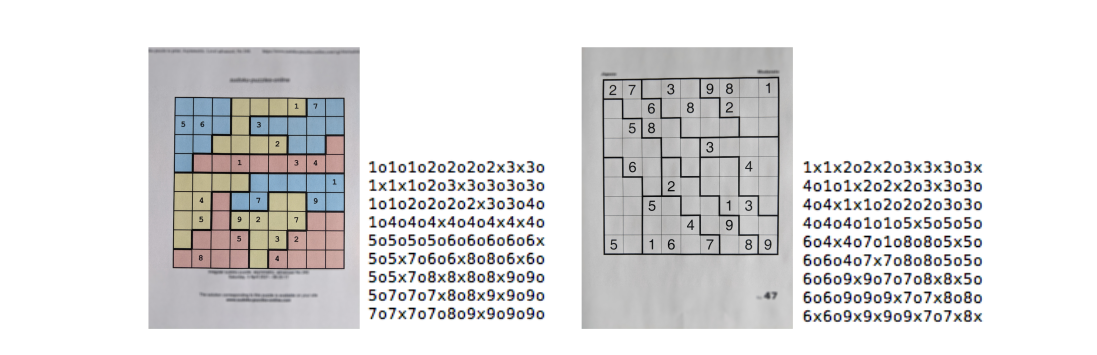

# Proposed Solution
Based on the solution from Task 1, now we have a robust method to detect the Sudoku Square.

### For the second task we need to find a way remove thin edges without losing thick edges, which describe each region.

Based on the new preprocessed image (only with thick edges) and the fact that we know that our image contains a 9x9 grid with fixed positions for possible borders, we can predict based on the intensity of a patch of pixels and some threshold if a certain position contains a region border. 

This way we can generate a grid matrix with borders that will be used for predicting each region.

For infering digits will use the same approach as in Task 1.

### The algorithm becomes
For each image that we have:
- Choose a robust preprocessing way to be able to detect the sudoku square without noise
- Apply a Canny Filter for edge detection (it's easier to find contours there)
- Generate all posible contours on that image
- Pick the "best" contour (this ideally represents the Sudoku Square, attention, this might not be the largest square in the image)
- Apply a perspective transform based on the (ordered) corners of that contour to remove possible rotations
- Apply some more preprocessing to the obtained image for removig thin edges, but keeping region borders 
- Based on the fact that we now the obtained image should be a 9x9 grid, iterate through patches of pixels
- Based on a chosen threshold and the mean intensity of the patch, predict if the image contains or not a region border
- Generate a grid matrix with borders for generating regions
- Apply a coloring algorithm for predict regions based on the grid
- Use the methodology from task 1 to predict possible digits in the Sudoku Square

# Implementation

# The coloring algorithm based on the generated grid

In [8]:
# Pretty standard algorithm for coloring (fill) regions based on grid matrix with 4 directions
def compute_colors_from_grid(grid):
    color = 0
    queue = []
    colors = np.zeros((9, 9), dtype = np.uint8)
    visited = np.zeros((9, 9), dtype = np.uint8)

    for k in range(9):
        for t in range(9):
            if visited[k][t] == 0:
                i = k; j = t
                color += 1
                queue.append((i, j))

                while len(queue) != 0:
                    (i, j) = queue.pop(0) 

                    visited[i][j] = 1
                    colors[i][j] = color

                    if grid[2 * i - 1][2 * j] != 1 and i - 1 >= 0 and visited[i - 1][j] == 0:
                        queue.append((i - 1, j))

                    if grid[2 * i][2 * j - 1] != 1 and j - 1 >= 0 and visited[i][j - 1] == 0:
                        queue.append((i, j - 1))

                    if grid[2 * i][2 * j + 1] != 1 and j + 1 < 9 and visited[i][j + 1] == 0:
                        queue.append((i, j + 1))

                    if grid[2 * i + 1][2 * j] != 1 and i + 1 < 9 and visited[i + 1][j] == 0:
                        queue.append((i + 1, j))

    return colors

In [9]:
# Function to evaluate prediction for task 2
def evaluate_results_task2(predictions_path,ground_truth_path,verbose = 0):
    total_correct = 0
    for i in range(1,41):
        filename_predictions = predictions_path + "/" + str(i) + "_predicted.txt"
        p = open(filename_predictions,"rt")        
        filename_ground_truth = ground_truth_path + "/" + str(i) + "_gt.txt"
        gt = open(filename_ground_truth,"rt")
        correct_flag = 1
        for row in range(1,10):
            p_line = p.readline()
            gt_line = gt.readline()
            #print(p_line)
            #print(gt_line)
            if (p_line[:19] != gt_line[:19]):
                print("Error in file {} at row: {}".format(filename_predictions, row))
                # print(len(p_line[:19]))
                # print(len(gt_line[:19]))
                print("Prediction: ", p_line[:19])
                print("Ground Truth: ", gt_line[:19])
                correct_flag = 0        
        p.close()
        gt.close()
        
        if verbose:
            print("Task 2 - Jigsaw Sudoku: for test example number ", str(i), " the prediction is :", (1-correct_flag) * "in" + "correct", "\n")
        
        total_correct = total_correct + correct_flag
        points = total_correct * 0.05

        #break
        
    return total_correct, points

# Task 2 Complete Pipeline

In [10]:
def run_task_two(PATH_TO_IMAGES, PATH_TO_PREDICTIONS, EVAL = False, verbose = False):
    image_paths = sorted(glob.glob(PATH_TO_IMAGES + os.sep + "*.jpg"))

    mean, std = compute_mean_and_std(image_paths, display = False)

    #mean, std = 239115.43, 55094.31

    for (step, path) in enumerate(image_paths):
        print("Inference at file: {}".format(path))
        file_name = path.split(os.sep)[-1].split(".")[0]
        path_to_prediction_file = os.path.join(PATH_TO_PREDICTIONS, file_name + "_predicted.txt")
        prediction_file = open(path_to_prediction_file, 'w')

        image = cv.imread(path)
        image = cv.resize(image, None, fx = 0.2, fy = 0.2)
        gray  = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
        
        if verbose:
            plt.figure(figsize = (8, 8))
            plt.imshow(image)
            plt.title(file_name)
            plt.show()

        preprocessed_image = preprocessing(gray)
        edges = cv.Canny(preprocessed_image, 150, 250)
        contours, hierarchy = cv.findContours(edges, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

        idx = generate_crop(contours, mean, std)  
        cnt = contours[idx]

        perimeter = cv.arcLength(cnt, True)
        corners   = cv.approxPolyDP(cnt, 0.01 * perimeter, True)
        corners   = order_points(corners)

        generated_height, generated_width = 540, 540
        warp_start = corners.astype(np.float32)

        warp_end   = np.array([
            [0, 0],
            [generated_width, 0],
            [0, generated_height],
            [generated_width, generated_height]]).astype(np.float32)

        warp_matrix = cv.getPerspectiveTransform(warp_start, warp_end)
        warp = cv.warpPerspective(image, warp_matrix, dsize = (generated_width, generated_height)) 

        # Preprocessing for removing thin edges
        warp = cv.cvtColor(warp, cv.COLOR_BGR2GRAY)
        thresh = cv.adaptiveThreshold(warp, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 37, 21)

        kernel = np.ones((5, 5), np.uint8)
        thresh  = cv.dilate(thresh, kernel, iterations = 1)

        kernel = np.ones((3, 3), np.uint8)
        thresh  = cv.erode(thresh, kernel, iterations = 1)

        thresh = cv.resize(thresh, (560, 560))
        thresh = thresh[10 : -10, 10 : -10]
        
        if verbose:
            plt.figure(figsize = (8, 8))
            plt.imshow(thresh)
            plt.title(file_name)
            plt.show()

        threshold = 235
        step = generated_height // 9

        # Predicting borders in Sudoku Square
        # Generating Grid Matrix
        margin = 15
        small_error = 10
        grid = np.zeros((18, 18), dtype = np.uint8)
        for row in range(0, thresh.shape[0], step):
            for column in range(0, thresh.shape[1], step):
                patch = thresh[row : row + step, column : column + step] 
                right = thresh[row + small_error : row + step - small_error, column + step - margin : column + step + margin]
                down  = thresh[row + step - margin : row + step + margin, column + small_error : column + step - small_error]

                i = row // step
                j = column // step

                if right.mean() < threshold:
                    grid[2 * i][2 * j + 1] = 1
                    grid[2 * i + 1][2 * j + 1] = 1
                
                if down.mean() < threshold:
                    grid[2 * i + 1][2 * j] = 1                    
                    grid[2 * i + 1][2 * j + 1] = 1

                # print("Right Mean: ", right.mean())
                # print("Down  Mean: ", down.mean())

                # cv.imshow("right", right)
                # cv.waitKey(0)

                # cv.imshow("down", down)
                # cv.waitKey(0)

        
        # Predicting region colors
        colors = compute_colors_from_grid(grid)
        
        if verbose:
            print("Borders Grid")
            print(grid)
            print("Region Colors")
            print(colors)

        # Predicting possible digits
        predictions = []
        thresh = cv.adaptiveThreshold(warp, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 5, 20)
        threshold = 250
        step = generated_height // 9
        for row in range(0, thresh.shape[0], step):
            prediction = []
            for column in range(0, thresh.shape[1], step):
                patch = thresh[row : row + step, column : column + step]
                patch = patch[10 : -10, 10 : -10]
                mean_color = patch.mean()
                
                if mean_color < threshold:
                    prediction.append("x")
                else:
                    prediction.append("o")

            predictions.append(prediction)

        predictions = np.array(predictions)

        for i in range(9):
            for j in range(9):
                prediction_file.write(str(colors[i][j]))
                prediction_file.write(predictions[i][j])

            if i == 8 and j == 8:
                continue

            prediction_file.write('\n')

        prediction_file.close()

    if EVAL:
        total_correct, points = evaluate_results_task2(PATH_TO_PREDICTIONS, PATH_TO_IMAGES, verbose = 10)
        print("Total Corrects: {}, Task Points: {}".format(total_correct, points))
        exit(1)

# Run Task 2
- PATH_TO_IMAGES -> (relative path example: "/train/jigsaw/")
- PATH_TO_PREDICTIONS -> (relative path example: "/oof/jigsaw/")
- EVAL -> Used for validation if the images folder contain labels (True / False)
- VERBOSE -> Display more stages of current task (True / False)

In [11]:
EVAL = True
VERBOSE = False
SCOPE = "jigsaw"
PATH_TO_TRAIN  = "train" + os.sep

PATH_TO_IMAGES = os.path.join(PATH_TO_TRAIN, SCOPE)
PATH_TO_PREDICTIONS = os.path.join("oof" + os.sep, SCOPE)

run_task_two(PATH_TO_IMAGES, PATH_TO_PREDICTIONS, EVAL, VERBOSE)

Inference at file: train/jigsaw/1.jpg
Inference at file: train/jigsaw/10.jpg
Inference at file: train/jigsaw/11.jpg
Inference at file: train/jigsaw/12.jpg
Inference at file: train/jigsaw/13.jpg
Inference at file: train/jigsaw/14.jpg
Inference at file: train/jigsaw/15.jpg
Inference at file: train/jigsaw/16.jpg
Inference at file: train/jigsaw/17.jpg
Inference at file: train/jigsaw/18.jpg
Inference at file: train/jigsaw/19.jpg
Inference at file: train/jigsaw/2.jpg
Inference at file: train/jigsaw/20.jpg
Inference at file: train/jigsaw/21.jpg
Inference at file: train/jigsaw/22.jpg
Inference at file: train/jigsaw/23.jpg
Inference at file: train/jigsaw/24.jpg
Inference at file: train/jigsaw/25.jpg
Inference at file: train/jigsaw/26.jpg
Inference at file: train/jigsaw/27.jpg
Inference at file: train/jigsaw/28.jpg
Inference at file: train/jigsaw/29.jpg
Inference at file: train/jigsaw/3.jpg
Inference at file: train/jigsaw/30.jpg
Inference at file: train/jigsaw/31.jpg
Inference at file: train/jig

# Task 3 - assembling a Sudoku Cube
In the third task you are asked to write a program that processes an input image containing three sides (each side is a sudoku puzzles) of a Sudoku Cube and outputs the coresponding Sudoku Cube by: 

(1) localizing the three sudoku puzzles in the image that form the sides of the Sudoku Cube; 

(2) inferring their position in the Sudoku Cube using the constraint that the digits on the common edge of two sides must be the same number; 

(3) warping each side on the corresponding side of a given template for the Sudoku Cube. 

The training data consists of 10 training examples. Each training example (an image 1500 × 1500 generated
on the computer) contains three sides of a Sudoku Cube . They are scattered around the image and usually rotated with respect to the axis. First, you have to find the three sudoku puzzles in the image, recognize the digits in each puzzle and solve the simple problem of matching the sides in the Sudoku cube. Please note that there is one solution.

Then you have to warp the puzzles on the template in order to obtain the desired result.

For warping, you are allowed to manually annotate points on the template for warping (but, of course, your are not allowed to to the same thing on the test images as we want your method to be automatically) such that it is easy to map each puzzle found in the image on the corresponding side of the Cube.

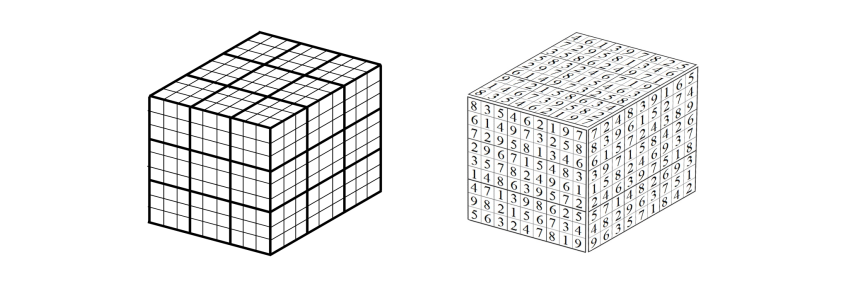

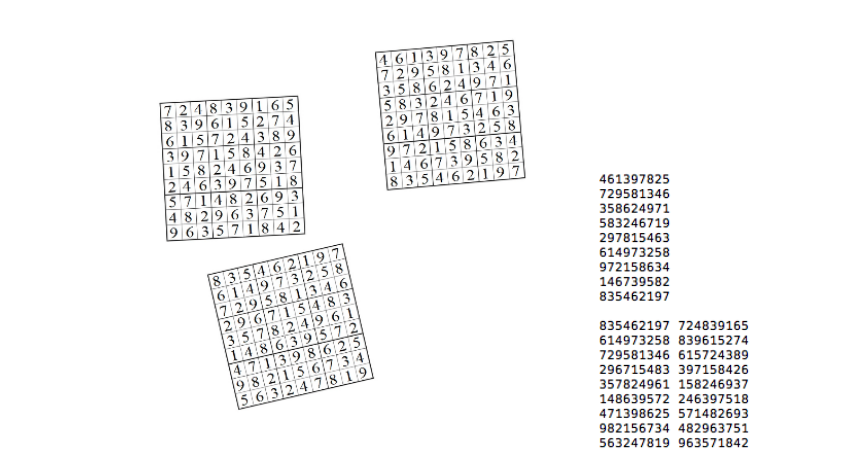

# Proposed Solution
For this task we will change the methodology for initial preprocessing, using just some 3x3 dilation for more pronounced edges, and choosing the biggest three contours based on the bounding rectangle area.

After the standard perspective transform we will use a Convolutional Neural Network trained some time ago.

(https://github.com/AdrianIordache/DeepLearning-In-Pytorch/blob/master/Transfer-Learning-On-Counting-MNIST-Dataset/Assignment-2.ipynb)

The accuracy at that time was about 99.3%, to improve that I decided to use 3 crops of TTA (Test Time Augmentation) 
averaging them before the argmax layer to obtain the final prediction.

For each sudoku square we will compare the top row with with each sudoku square buttom row to obtain a reindexing of squares for the final prediction file.

Based on the same indexing will wrap the corners of detected squares to the annotated corners of the template image.


# Implementation

# Convolutional Neural Network

In [12]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

class ConvolutionalNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 30, kernel_size = 3, stride = 1)
        self.conv2 = nn.Conv2d(in_channels = 30, out_channels = 60, kernel_size = 2, stride = 1)
        self.conv3 = nn.Conv2d(in_channels = 60, out_channels = 100, kernel_size = 3, stride = 1)
        
        self.fc1 = nn.Linear(in_features = 2 * 2 * 100, out_features = 256)
        self.fc2 = nn.Linear(in_features = 256, out_features = 128)
        self.fc3 = nn.Linear(in_features = 128, out_features = 64)
        self.fc4 = nn.Linear(in_features = 64, out_features = 10)
        
    def forward(self, x):
        #print(x.shape)
        x = F.relu(self.conv1(x))
        #print(x.shape)
        x = F.max_pool2d(x, 2, 2)
        #print(x.shape)
        x = F.relu(self.conv2(x))
        #print(x.shape)
        x = F.max_pool2d(x, 2, 2)
        #print(x.shape)
        x = F.relu(self.conv3(x))
        #print(x.shape)
        x = F.max_pool2d(x, 2, 2)
        #print(x.shape)
        
        x = x.view(-1, 2 * 2 * 100)
        #print(x.shape)
        x = F.relu(self.fc1(x))
        #print(x.shape)
        x = F.relu(self.fc2(x))
        #print(x.shape)
        x = F.relu(self.fc3(x))
        #print(x.shape)
        x = self.fc4(x)
        
        return x

In [13]:
# Function to evaluate task three
def evaluate_results_task3(predictions_path,ground_truth_path, verbose = 0):
    total_correct = 0
    for i in range(1,11):
        filename_predictions = predictions_path + "/" + str(i) + "_predicted.txt"
        p = open(filename_predictions,"rt")        
        filename_ground_truth = ground_truth_path + "/" + str(i) + "_gt.txt"
        gt = open(filename_ground_truth,"rt")
        correct_flag = 1
        for row in range(1,10):
            p_line = p.readline()
            gt_line = gt.readline()
            #print(p_line)
            #print(gt_line)
            if (p_line[:10] != gt_line[:10]):
                print("Error in file {} at row: {}".format(filename_predictions, row))
                # print(len(p_line[:19]))
                # print(len(gt_line[:19]))
                print("Prediction: ", p_line[:10])
                print("Ground Truth: ", gt_line[:10])

                correct_flag = 0
        
        p_line = p.readline()
        gt_line = gt.readline()
        
        for row in range(1,10):
            p_line = p.readline()
            gt_line = gt.readline()
            #print(p_line)
            #print(gt_line)
            if (p_line[:20] != gt_line[:20]):
                print("Error in file {} at row: {}".format(filename_predictions, row))
                # print(len(p_line[:19]))
                # print(len(gt_line[:19]))
                print("Prediction: ", p_line[:20])
                print("Ground Truth: ", gt_line[:20])
                correct_flag = 0
        p.close()
        gt.close()
        
        if verbose:
            print("Task 3 - Sudoku Cube: for test example number ", str(i), " the prediction is :", (1-correct_flag) * "in" + "correct", "\n")
        
        total_correct = total_correct + correct_flag
        points = total_correct * 0.05
        # break

    return total_correct, points 

# Task 3 Complete Pipeline

In [14]:
def run_task_three(PATH_TO_IMAGES, PATH_TO_PREDICTIONS, EVAL = False, verbose = False):
    image_paths = sorted(glob.glob(PATH_TO_IMAGES + os.sep + "*.jpg"))
    
    # Convloutional Neural Network Initialization
    model = ConvolutionalNeuralNetwork()
    model.load_state_dict(torch.load("classification_net.pt"))
    model.to('cpu')

    # Template Image
    template = cv.imread(PATH_TO_IMAGES + os.sep + "template.jpg")

    # Annotated Points on template image
    cube_points = [
        np.array([[273, 4], [559, 84], [9,  156], [296, 234]]).astype(np.float32),
        np.array([[6, 160], [297, 236], [5,  462], [294, 540]]).astype(np.float32),
        np.array([[297, 237], [563, 85], [299,  536], [564, 386]]).astype(np.float32)
    ]

    for (step, path) in enumerate(image_paths):
        print("Inference at file: {}".format(path))
        if 'result' in path or 'template' in path: continue

        file_name = path.split(os.sep)[-1].split(".")[0]
        path_to_prediction_file = os.path.join(PATH_TO_PREDICTIONS, file_name + "_predicted.txt")
        prediction_file = open(path_to_prediction_file, 'w')

        image = cv.imread(path)
        image = cv.resize(image, None, fx = 1.4, fy = 1.4)
        gray  = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

        edges = cv.Canny(gray, 150, 250)

        # Dilation for more pronounced edges
        kernel = np.ones((3, 3), np.uint8)
        edges  = cv.dilate(edges, kernel, iterations = 1)

        contours, hierarchy = cv.findContours(edges, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

        areas = []
        for cnt in contours:
            x, y, w, h = cv.boundingRect(cnt)  
            area = w * h
            areas.append(area)

        # Finding the largest three contours
        areas = np.array(areas)
        idx = np.argpartition(areas, -3)[-3:] 
        indices = idx[np.argsort((-areas)[idx])]

        # Digits for each face of the cube
        faces = []
        for idxs in indices:
            cnt = contours[idxs]

            perimeter = cv.arcLength(cnt, True)
            corners   = cv.approxPolyDP(cnt, 0.01 * perimeter, True)
            corners   = order_points(corners)

            generated_height, generated_width = 810, 810
            warp_start = corners.astype(np.float32)

            warp_end   = np.array([
                [0, 0],
                [generated_width, 0],
                [0, generated_height],
                [generated_width, generated_height]]).astype(np.float32)

            warp_matrix = cv.getPerspectiveTransform(warp_start, warp_end)
            warp = cv.warpPerspective(image, warp_matrix, dsize = (generated_width, generated_height)) 

            warp = cv.cvtColor(warp, cv.COLOR_BGR2GRAY)

            # warp = cv.GaussianBlur(warp, (5, 5), 0)
            # warp = cv.adaptiveThreshold(warp, 255, 1, 1, 11, 2)

            # kernel = np.array([[-1,-1,-1], [-1, 9, -1], [-1,-1,-1]])
            # warp = cv.filter2D(warp, -1, kernel)
            # cv.imshow("image", warp)
            # cv.waitKey(0)

            digits = np.zeros((9, 9), dtype = np.uint8)
            step = generated_height // 9
            for row in range(0, warp.shape[0], step):
                for column in range(0, warp.shape[1], step):
                    patch = warp[row : row + step, column : column + step]   
                    patch = cv.bitwise_not(patch)

                    # Removing Margins with noise
                    patch[: 10, :] = 0
                    patch[:, : 10] = 0
                    patch[-10 :, :] = 0
                    patch[:, -10 :] = 0

                    i = row // step
                    j = column // step
                    
                    # 3 Crops of TTA
                    patch_1 = cv.resize(patch, (28, 28))

                    kernel  = np.array([[-1,-1,-1], [-1, 9, -1], [-1,-1,-1]])
                    patch_2 = cv.filter2D(patch_1, -1, kernel)
                    
                    kernel  = np.ones((2, 2), np.uint8)
                    patch_3 = cv.dilate(patch_1, kernel, iterations = 1)

                    image_tensor_1 = torch.tensor(transform(patch_1))

                    image_tensor_2 = torch.tensor(transform(patch_2))

                    image_tensor_3 = torch.tensor(transform(patch_3))

                    batch = torch.stack([image_tensor_1, image_tensor_2, image_tensor_3], dim = 0)

                    # print(batch.shape)
                    output = model(batch.float()).squeeze(0)

                    preds  = torch.argmax(torch.mean(output, dim = 0))
                    #print(preds.item())

                    digits[i][j] = preds.item()

                    # cv.imshow("digit", patch_1)
                    # cv.waitKey(0)
            
            faces.append(digits)
            # cv.imshow("image", warp)
            # cv.waitKey(0)
            # break

        up_idx   = None
        down_idx = None

        # Rearranging faces for prediction file
        faces = np.array(faces)
        for i in range(faces.shape[0]):
            up_row = faces[i][0][:]
            for j in range(faces.shape[0]):
                down_row = faces[j][-1][:]
                if (up_row == down_row).all():
                    print("Match Found")
                    up_idx = j
                    down_idx = i

        idx = [up_idx, down_idx, 3 - up_idx - down_idx]
        faces = faces[idx]

        for i in range(9):
            for j in range(9):
                prediction_file.write(str(faces[0][i][j]))

            prediction_file.write('\n') 

        prediction_file.write('\n')
        for i in range(9):
            for j in range(9 * 2 + 1):
                if j < 9:
                    prediction_file.write(str(faces[1][i][j]))

                if j == 9:
                    prediction_file.write(' ')
                    continue

                if j > 9:
                    prediction_file.write(str(faces[2][i][j % 9 - 1]))

            if i == 8 and j == 18:
                continue

            prediction_file.write('\n')

        prediction_file.close()

        # Mapping sudoku squares to the cube
        indices = indices[idx]
        for (i, idxs) in enumerate(indices):
            cnt = contours[idxs]

            perimeter = cv.arcLength(cnt, True)
            corners   = cv.approxPolyDP(cnt, 0.01 * perimeter, True)
            corners   = order_points(corners)

            generated_height, generated_width = template.shape[0], template.shape[1]
            warp_start = corners.astype(np.float32)

            warp_cube = cube_points[i] 
            warp_end = np.array([
                [0, 0],
                [generated_width, 0],
                [0, generated_height],
                [generated_width, generated_height]]).astype(np.float32)

            warp_matrix = cv.getPerspectiveTransform(warp_start, warp_end)
            warp = cv.warpPerspective(image, warp_matrix, dsize = (generated_width, generated_height))

            warp_matrix = cv.getPerspectiveTransform(warp_end, warp_cube)
            warp = cv.warpPerspective(warp, warp_matrix, dsize = (generated_width, generated_height))

            template[warp > 0] = 0  
            template += warp * (warp > 0) 
            
        if verbose:
            plt.figure(figsize = (8, 8))
            plt.imshow(template)
            plt.title(file_name)
            plt.show()

        path_to_prediction_image = os.path.join(PATH_TO_PREDICTIONS, file_name + "_result.jpg")
        cv.imwrite(path_to_prediction_image, template)

    if EVAL:
        total_correct, points = evaluate_results_task3(PATH_TO_PREDICTIONS, PATH_TO_IMAGES, verbose = 10)
        print("Total Corrects: {}, Task Points: {}".format(total_correct, points))
        exit(1)    

# Run Task 3
- PATH_TO_IMAGES -> (relative path example: "/train/cube/")
- PATH_TO_PREDICTIONS -> (relative path example: "/oof/cube/")
- EVAL -> Used for validation if the images folder contain labels (True / False)
- VERBOSE -> Display more stages of current task (True / False)

### Note: the convolutional network should be in the base folder and template image in the images folder

In [15]:
EVAL = True
VERBOSE = False
SCOPE = "cube"
PATH_TO_TRAIN  = "train" + os.sep

PATH_TO_IMAGES = os.path.join(PATH_TO_TRAIN, SCOPE)
PATH_TO_PREDICTIONS = os.path.join("oof" + os.sep, SCOPE)

run_task_three(PATH_TO_IMAGES, PATH_TO_PREDICTIONS, EVAL, VERBOSE)

Inference at file: train/cube/1.jpg
Match Found
Inference at file: train/cube/10.jpg
Match Found
Inference at file: train/cube/10_result.jpg
Inference at file: train/cube/1_result.jpg
Inference at file: train/cube/2.jpg
Match Found
Inference at file: train/cube/2_result.jpg
Inference at file: train/cube/3.jpg
Match Found
Inference at file: train/cube/3_result.jpg
Inference at file: train/cube/4.jpg
Match Found
Inference at file: train/cube/4_result.jpg
Inference at file: train/cube/5.jpg
Match Found
Inference at file: train/cube/5_result.jpg
Inference at file: train/cube/6.jpg
Match Found
Inference at file: train/cube/6_result.jpg
Inference at file: train/cube/7.jpg
Match Found
Inference at file: train/cube/7_result.jpg
Inference at file: train/cube/8.jpg
Match Found
Inference at file: train/cube/8_result.jpg
Inference at file: train/cube/9.jpg
Match Found
Inference at file: train/cube/9_result.jpg
Inference at file: train/cube/template.jpg
Task 3 - Sudoku Cube: for test example number